In [4]:
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.special as ss
import scipy.integrate as si
import scipy.optimize as so
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.numpy.linalg as jnl
from jax.config import config
config.update("jax_enable_x64", True)

In [14]:
# size of spatial domain
L = 10.0
# number of real space grid points (for plotting)
numx = 1025
# real space grid points (for plotting)
xvec = np.linspace(-L, L, numx)

# number of Fourier basis functions
# n = -numF to n = numF
numfour = 32  # 32

# matrix for converting Fourier representation to real space
fournvec = np.arange(-numfour, numfour + 1) # fournvec=-nfb,...,0,...,nfb
fourtox = np.exp(1j * np.pi * np.outer(fournvec, xvec) / L) / np.sqrt(2 * L)
print('Shape fourtox:', fourtox.shape)

Shape fourtox: (65, 1025)


L2 error of |avec @ fourtox|^2:
3.258307105675155e-07
L2 error of betavec:
2.3885019620271058e-11


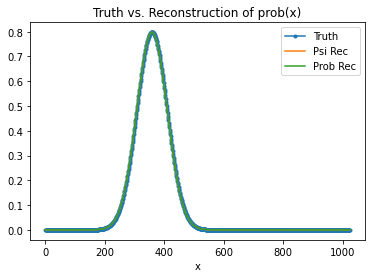

In [24]:
# define initial states and transform to Fourier basis

def psi(x):
    return np.exp(-(x + 3)**2 / 4) * (2.0 / np.pi)**0.25
    # return np.exp(-(x - 3)**2 / 4) * (2.0 / np.pi)**0.25
    # return np.exp(-(x - 6)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-(x + 6)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-x**2) * (2.0 / np.pi)**0.25

psitoep = []
for thisfourn in range (numfour + 1):
    def intgrnd(x):
        return psi(x) * np.exp(-1j * np.pi * thisfourn * x / L) / np.sqrt(2 * L)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    psitoep.append(si.quad(rintgrnd, -L, L)[0] + 1j * si.quad(iintgrnd, -L, L)[0])

avec = np.concatenate([np.conjugate(np.flipud(psitoep[1:])), psitoep])

prob = lambda x: np.abs(psi(x))**2

print('L2 error of |avec @ fourtox|^2:', nl.norm(prob(xvec) - np.abs(avec @ fourtox)**2), sep='\n')

probtoep = []
for thisfourn in range (numfour + 1):
    def intgrnd(x):
        return prob(x) * np.exp(-1j * np.pi * thisfourn * x / L) / np.sqrt(2 * L)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    probtoep.append(si.quad(rintgrnd, -L, L)[0] + 1j * si.quad(iintgrnd, -L, L)[0])

betavec = np.concatenate([np.conjugate(np.flipud(probtoep[1:])), probtoep])

print('L2 error of betavec:', nl.norm(prob(xvec) - np.real(betavec @ fourtox)), sep='\n')

# plot truth vs reconsturction of prob(x)
plt.plot(prob(xvec), '.-', label='Truth')
plt.plot(np.abs(avec @ fourtox)**2, label='Psi Rec')
plt.plot(np.real(betavec @ fourtox), label='Prob Rec')
plt.title('Truth vs. Reconstruction of prob(x)')
plt.xlabel('x')
plt.legend()
plt.show()

In [26]:
objective = 0
for j in range(-numfour, numfour+1):
    thissum = 0
    for k in range(-numfour, numfour+1):
        if np.abs(j + k) <= numfour:
            thissum += avec[j + k + numfour] * np.conj(avec[k + numfour])
    fourprob = (thissum / np.sqrt(2 * L))
    err = np.abs(fourprob - betavec[j + numfour])**2
    objective += err

print(objective)

1.031532719821401e-15
